In [ ]:
!pip install datasets matplotlib torchvision --quiet

In [ ]:
# Install torch-lr-finder if not already installed
!pip install torch-lr-finder --upgrade

In [ ]:
!pip install albumentations --quiet

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from datasets import load_dataset
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from torch.utils.data import Dataset

import torch.optim as optim
from torch_lr_finder import LRFinder
from torch.utils.data import Subset, DataLoader


from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

In [ ]:
# Load ImageNet-100 from Hugging Face
dataset = load_dataset("clane9/imagenet-100")

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

data/train-00000-of-00017.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

data/train-00001-of-00017.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

data/train-00002-of-00017.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

data/train-00003-of-00017.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

data/train-00004-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

data/train-00005-of-00017.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

data/train-00006-of-00017.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

data/train-00007-of-00017.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

data/train-00008-of-00017.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

data/train-00009-of-00017.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

data/train-00010-of-00017.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

data/train-00011-of-00017.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

data/train-00012-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

data/train-00013-of-00017.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

data/train-00014-of-00017.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00015-of-00017.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

data/train-00016-of-00017.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/126689 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# For now, no transforms needed for display
train_dataset = dataset['train']
val_dataset = dataset['validation']

Sample 1: Label=13, Type=<class 'PIL.PngImagePlugin.PngImageFile'>, Size=(160, 213), Mode=RGB
Sample 2: Label=33, Type=<class 'PIL.PngImagePlugin.PngImageFile'>, Size=(213, 160), Mode=RGB
Sample 3: Label=32, Type=<class 'PIL.PngImagePlugin.PngImageFile'>, Size=(238, 160), Mode=RGB
Sample 4: Label=67, Type=<class 'PIL.PngImagePlugin.PngImageFile'>, Size=(224, 160), Mode=RGB
Sample 5: Label=3, Type=<class 'PIL.PngImagePlugin.PngImageFile'>, Size=(160, 213), Mode=RGB


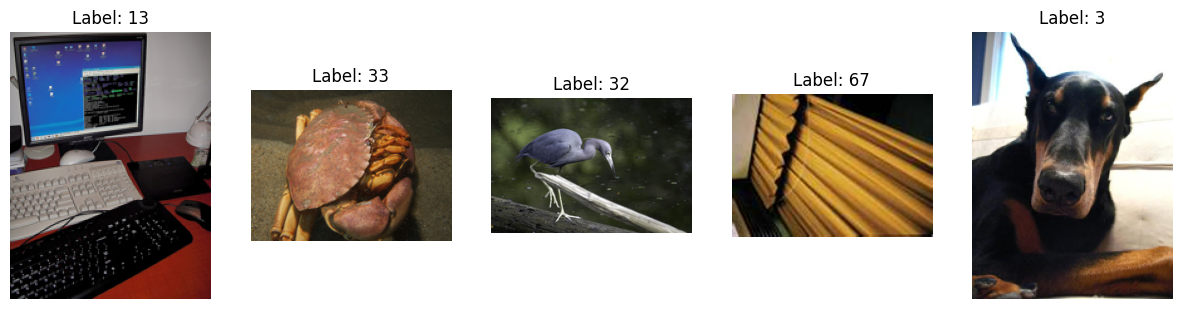

In [ ]:


# Pick 5 random indices
random_indices = random.sample(range(len(train_dataset)), 5)

plt.figure(figsize=(15,4))
for i, idx in enumerate(random_indices):
    sample = train_dataset[idx]
    img = sample['image']
    label = sample['label']

    # Display image
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

    # Print image info
    print(f"Sample {i+1}: Label={label}, Type={type(img)}, Size={img.size}, Mode={img.mode}")

plt.show()


In [ ]:
# import numpy as np
# from tqdm import tqdm

# def pil_to_np(img):
#     # Convert to RGB if not already
#     if img.mode != "RGB":
#         img = img.convert("RGB")
#     return np.array(img) / 255.0  # H,W,C with values 0-1

# mean = np.zeros(3)
# std = np.zeros(3)
# n = 0

# for sample in tqdm(train_dataset, desc="Calculating mean/std"):
#     img_np = pil_to_np(sample['image'])  # H,W,C
#     mean += img_np.mean(axis=(0,1))      # per channel mean
#     std += img_np.std(axis=(0,1))        # per channel std
#     n += 1

# mean /= n
# std /= n

# print("Dataset Mean:", mean)
# print("Dataset Std:", std)


In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),

    # Random scale first
    A.RandomScale(scale_limit=0.2, p=0.5),

    # Resize largest side to 224, preserve aspect ratio
    A.LongestMaxSize(max_size=224),

    # Pad smaller side to make exact 224x224
    A.PadIfNeeded(min_height=224, min_width=224,
                  border_mode=0, value=tuple([int(m*255) for m in mean])),

    A.CoarseDropout(
        max_holes=1,
        min_holes=1,
        max_height=16,
        min_height=16,
        max_width=16,
        min_width=16,
        fill_value=tuple([int(m*255) for m in mean]),
        mask_fill_value=None,
        p=0.5
    ),

    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.7),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.LongestMaxSize(max_size=224),
    A.PadIfNeeded(min_height=224, min_width=224,
                  border_mode=0, value=tuple([int(m*255) for m in mean])),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


In [ ]:
class ImageNet100Dataset(Dataset):
    def __init__(self, hf_dataset, transforms=None):
        self.dataset = hf_dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if img.mode != "RGB":
            img = img.convert("RGB")

        img = np.array(img)

        if self.transforms:
            img = self.transforms(image=img)['image']

        return img, label


In [ ]:
train_data = ImageNet100Dataset(train_dataset, transforms=train_transform)
val_data = ImageNet100Dataset(val_dataset, transforms=val_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


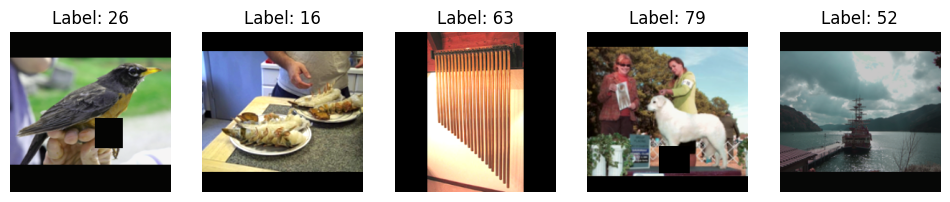

In [ ]:
# Get one batch
imgs, labels = next(iter(train_loader))

# Unnormalize
imgs_display = imgs.clone()
for c in range(3):
    imgs_display[:,c,:,:] = imgs_display[:,c,:,:] * std[c] + mean[c]
imgs_display = torch.clamp(imgs_display, 0, 1)

# Plot 5 random images
plt.figure(figsize=(12,4))
for i in range(5):
    img = imgs_display[i].permute(1,2,0).numpy()  # C,H,W -> H,W,C
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()


In [ ]:
# --- Basic Residual Block ---
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# --- ResNet-50 ---
class ResNet50(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*Bottleneck.expansion, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes*Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes*Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*Bottleneck.expansion)
            )
        layers = [Bottleneck(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes*Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# Mixed precision
scaler = GradScaler()

def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Train")

    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():  # mixed precision
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler:
            scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    epoch_loss = running_loss / total
    epoch_acc = 100.*correct/total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Val")

    with torch.no_grad():
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += imgs.size(0)
            pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    epoch_loss = running_loss / total
    epoch_acc = 100.*correct/total
    return epoch_loss, epoch_acc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.73E-05


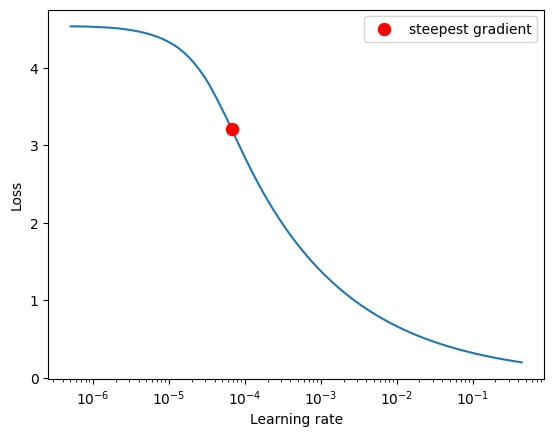

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model
model = ResNet50(num_classes=100).to(device)

# Criterion
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD)
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)

# Small subset for fast LR Finder
subset_indices = list(range(500))
small_dataset = Subset(train_data, subset_indices)
small_loader = DataLoader(small_dataset, batch_size=64, shuffle=True)

# LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(small_loader, end_lr=1.0, num_iter=100)  # SGD typical end_lr ~1.0
lr_finder.plot()  # inspect loss vs LR
lr_finder.reset() # reset model & optimizer


In [ ]:

max_lr = 7.92e-04           # 10× LR Finder suggestion
initial_lr = max_lr / 10    # = 7.92e-05

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=15,
    pct_start=0.3,
    div_factor=10,
    final_div_factor=1e4
)

# AMP scaler
scaler = GradScaler()

num_epochs = 15
for epoch in range(num_epochs):
    ############## TRAINING ##############
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=100.*correct/total, lr=optimizer.param_groups[0]['lr'])

    avg_train_loss = train_loss / total
    train_acc = 100. * correct / total

    ############## VALIDATION ##############
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / val_total
    val_acc = 100. * val_correct / val_total

    ############## EPOCH LOG ##############
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"| Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% "
          f"| LR: {optimizer.param_groups[0]['lr']:.6f}")


Epoch [1/15] | Train Loss: 4.4634 | Train Acc: 3.48% | Val Loss: 4.2194 | Val Acc: 6.66% | LR: 0.000163


Epoch [2/15] | Train Loss: 3.9190 | Train Acc: 10.40% | Val Loss: 3.6187 | Val Acc: 13.70% | LR: 0.000374


Epoch [3/15] | Train Loss: 3.3584 | Train Acc: 19.05% | Val Loss: 3.2434 | Val Acc: 20.56% | LR: 0.000614


Epoch [4/15] | Train Loss: 2.8874 | Train Acc: 27.90% | Val Loss: 2.9315 | Val Acc: 27.32% | LR: 0.000771


Epoch [5/15] | Train Loss: 2.5373 | Train Acc: 35.09% | Val Loss: 2.4639 | Val Acc: 36.38% | LR: 0.000788


Epoch [6/15] | Train Loss: 2.2689 | Train Acc: 41.03% | Val Loss: 2.3345 | Val Acc: 39.26% | LR: 0.000753


Epoch [7/15] | Train Loss: 2.0461 | Train Acc: 46.20% | Val Loss: 2.0837 | Val Acc: 44.74% | LR: 0.000686


Epoch [8/15] | Train Loss: 1.8499 | Train Acc: 50.81% | Val Loss: 2.4092 | Val Acc: 40.32% | LR: 0.000594


Epoch [9/15] | Train Loss: 1.6817 | Train Acc: 54.90% | Val Loss: 1.8844 | Val Acc: 50.30% | LR: 0.000484


Epoch [10/15] | Train Loss: 1.5294 | Train Acc: 58.70% | Val Loss: 1.7319 | Val Acc: 53.52% | LR: 0.000366


Epoch [11/15] | Train Loss: 1.3851 | Train Acc: 62.30% | Val Loss: 1.6419 | Val Acc: 55.48% | LR: 0.000251


Epoch [12/15] | Train Loss: 1.2466 | Train Acc: 65.72% | Val Loss: 1.5676 | Val Acc: 57.88% | LR: 0.000149


Epoch [13/15] | Train Loss: 1.1152 | Train Acc: 69.43% | Val Loss: 1.5010 | Val Acc: 59.10% | LR: 0.000069


Epoch [14/15] | Train Loss: 0.9963 | Train Acc: 72.66% | Val Loss: 1.4357 | Val Acc: 60.78% | LR: 0.000018


Epoch [15/15] | Train Loss: 0.9307 | Train Acc: 74.78% | Val Loss: 1.4261 | Val Acc: 61.36% | LR: 0.000000
